## RNA-seq: Differential Expression of Transcription Factors


In addition to ATAC-STARR-seq, we also performed RNA-seq on the GM12878 and LCL8664 cell lines for two replicates each. Importantly, we simulated electroportation and cell response at 24 hours to foreign dsDNA as a means to capture transcript levels when ATAC-STARR-seq samples were harvested. With this data, we want to identify differentially expressed genes and pathways as a complement to the regulatory differeences we capture in ATAC-STARR. 

This comparative expression analysis between species is tricky though, because when done improperly many false positives can arise. For example othologs that are 2:1 or 3:1 would need 3 times as much RNA to seem to be at the same level in case vs. another. For that reason we only want to consider genes with 1:1 orthologs. While this seems easy enough at face, it is remarkably complex. To help myself, I'll be using an exon file generated by XSAnno. 

The first thing is to download the hg19-rheMac2 file from XSAnno for each genome and liftOver to hg38/rheMac10. There is no rheMac2 to rheMac10, so go to 8 then 10. 

Note: I did this code awhile ago and am placing it here for documentation sake. I am not re-running it.

In [ ]:
%%bash
#download xsanno files.  

cd /data/hodges_lab/ATAC-STARR_V2/data/RNA-seq
#Hg
wget 'https://hbatlas.org/xsanno/files/Ensembl-v64-Human-Macaque/Ensembl.v64.fullTransExon.hg19TorheMac2.hg19.bed.gz'
gunzip Ensembl.v64.fullTransExon.hg19TorheMac2.hg19.bed.gz
liftOver Ensembl.v64.fullTransExon.hg19TorheMac2.hg19.bed \
  /data/hodges_lab/bin/map.chain/hg19ToHg38.over.chain.gz \
  Ensembl.v64.fullTransExon.hg19TorheMac2.hg38.bed Ensembl.v64.fullTransExon.hg19TorheMac2.unmapped.bed

#rheMac
wget 'https://hbatlas.org/xsanno/files/Ensembl-v64-Human-Macaque/Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac2.bed.gz'
gunzip Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac2.bed.gz

liftOver Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac2.bed \
  /data/hodges_lab/bin/map.chain/rheMac2ToRheMac8.over.chain.gz \
  Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac8.bed Ensembl.v64.fullTransExon.hg19TorheMac2.unmapped.bed

liftOver Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac8.bed \
  /data/hodges_lab/bin/map.chain/rheMac8ToRheMac10.over.chain.gz \
  Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac10.bed Ensembl.v64.fullTransExon.hg19TorheMac2.unmapped2.bed

In [ ]:
%%bash
#Convert bed files to gtf format for use in featureCounts. This awk statement re-orders columns and shifts the coordinate index. 

cd /data/hodges_lab/ATAC-STARR_V2/data/RNA-seq
awk '{print $1"\t""XSAnno_ensembl""\t""exon""\t"($2+1)"\t"$3"\t"".""\t"$6"\t"".""\t"$4}' Ensembl.v64.fullTransExon.hg19TorheMac2.hg38.bed | awk 'BEGIN {FS="|";OFS="\t"}{print $1,$2,$8}' - | awk 'BEGIN {FS=";";OFS="\t"}{print $1,$2,$3}' - | awk 'BEGIN{FS="\t";OFS=""}{print $1,"\t",$2,"\t",$3,"\t",$4,"\t",$5,"\t",$6,"\t",$7,"\t",$8,"\t","gene_id ","\"",$9,"\";"," transcript_id ","\"",$11,"\"; exon_number "$13}' | awk 'BEGIN{FS="Exon";OFS=""}{print $1,$2}' > Ensembl.v64.fullTransExon.hg19TorheMac2.hg38.gtf
awk '{print $1"\t""XSAnno_ensembl""\t""exon""\t"($2+1)"\t"$3"\t"".""\t"$6"\t"".""\t"$4}' Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac10.bed | awk 'BEGIN {FS="|";OFS="\t"}{print $1,$2,$8}' - | awk 'BEGIN {FS=";";OFS="\t"}{print $1,$2,$3}' - | awk 'BEGIN{FS="\t";OFS=""}{print $1,"\t",$2,"\t",$3,"\t",$4,"\t",$5,"\t",$6,"\t",$7,"\t",$8,"\t","gene_id ","\"",$9,"\";"," transcript_id ","\"",$11,"\"; exon_number "$13}' | awk 'BEGIN{FS="Exon";OFS=""}{print $1,$2}' > Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac10.gtf

### Trimming 

In [ ]:
%%bash
#Next trim and QC RNA-seq fastqs with trim galore! 
#Submitted this part as a slurm job. Script: RNA-seq_trimming.slrm

DATA_DIR='/data/hodges_lab/ATAC-STARR_V2/data/RNA-seq'
#GM12878
module restore trim_and_map
trim_galore --fastqc --fastqc_args "--outdir ${DATA_DIR}/processing_results/fastQC" \
    --paired --dont_gzip --basename GM12878_Rep1_RNA-seq --output_dir ${DATA_DIR}/fastq/trimmed_reads \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-1_S1_L005_R1_001.fastq.gz \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-1_S1_L005_R2_001.fastq.gz
trim_galore --fastqc --fastqc_args "--outdir ${DATA_DIR}/processing_results/fastQC" \
    --paired --dont_gzip --basename GM12878_Rep2_RNA-seq --output_dir ${DATA_DIR}/fastq/trimmed_reads \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-2_S1_L005_R1_001.fastq.gz \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-2_S1_L005_R2_001.fastq.gz
#LCL8664
trim_galore --fastqc --fastqc_args "--outdir ${DATA_DIR}/processing_results/fastQC" \
    --paired --dont_gzip --basename LCL8664_Rep1_RNA-seq --output_dir ${DATA_DIR}/fastq/trimmed_reads \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-3_S1_L005_R1_001.fastq.gz \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-3_S1_L005_R2_001.fastq.gz
trim_galore --fastqc --fastqc_args "--outdir ${DATA_DIR}/processing_results/fastQC" \
    --paired --dont_gzip --basename LCL8664_Rep2_RNA-seq --output_dir ${DATA_DIR}/fastq/trimmed_reads \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-4_S1_L005_R1_001.fastq.gz \
    ${DATA_DIR}/fastq/raw_reads/6231-TH-4_S1_L005_R2_001.fastq.gz

### Mapping with STAR
With trimming done, it is time to align the reads to the human and rhesus genomes. Because RNA reads can cross exon-exon junctions we will use the STAR aligner which does "splice-aware" aligning to avoid this. To use STAR, we must first build a STAR index. 

To build a STAR index we need ensembl gtfs and fasta files for each genome. The fasta files are available at the goldenpath on UCSC genome browser. I've already downloaded these files previously. Making a STAR index takes ~45m so this needs to be submitted as a job. The script was called, "RNA-seq_build-STAR-indexes.slrm".

In [ ]:
%%bash
 #download ensembl gtfs
wget 'http://ftp.ensembl.org/pub/release-104/gtf/homo_sapiens/Homo_sapiens.GRCh38.104.gtf.gz'
wget 'http://ftp.ensembl.org/pub/release-104/gtf/macaca_mulatta/Macaca_mulatta.Mmul_10.104.gtf.gz'

#Now ensembl doesn't have chr prefix, so add with awk. Also remove metadata header. 
awk 'BEGIN{OFS=""}{if (NR>5) print "chr",$0}' /data/hodges_lab/hg38_genome/Homo_sapiens.GRCh38.104.gtf > \
  /data/hodges_lab/hg38_genome/Homo_sapiens.GRCh38.104.modified.gtf
  
awk 'BEGIN{OFS=""}{if (NR>5) print "chr",$0}' /data/hodges_lab/rheMac10_genome/Macaca_mulatta.Mmul_10.104.gtf > \
  /data/hodges_lab/rheMac10_genome/Macaca_mulatta.Mmul_10.104.modified.gtf

In [ ]:
%%bash
#generate indexes
HG38_FA='/data/hodges_lab/hg38_genome/hg38.fa'
HG38_GTF='/data/hodges_lab/hg38_genome/Homo_sapiens.GRCh38.104.modified.gtf'
RHEMAC10_FA='/data/hodges_lab/rheMac10_genome/rheMac10.fa'
RHEMAC10=GTF='/data/hodges_lab/rheMac10_genome/Macaca_mulatta.Mmul_10.104.modified.gtf'
module restore STAR

#hg38
STAR --runThreadN 8 \
--runMode genomeGenerate \
--genomeDir /data/hodges_lab/hg38_genome/hg38_GTF-ensembl.104_index_149 \
--genomeFastaFiles $HG38_FA \
--sjdbGTFfile $HG38_GTF \
--sjdbOverhang 149 #overhang is maximum readlength-1. Since we use the novaseq at 2x150, this is 149.

#rheMac10
STAR --runThreadN 8 \
--runMode genomeGenerate \
--genomeDir /data/hodges_lab/rheMac10_genome/rheMac10_GTF-ensembl.104_index_149 \
--genomeFastaFiles $RHEMAC10_FA \
--sjdbGTFfile $RHEMAC10_GTF \
--sjdbOverhang 149 #overhang is maximum readlength-1. Since we use the novaseq at 2x150, this is 149.

In [ ]:
%%bash
#Now we are ready to map! Submit this as a job using the script: RNA-seq_mapping.slrm

## Map to transcriptiome with STAR aligner. 
#Output mapped files as well as readcounts per gene by setting --quantmode GeneCounts.
module restore STAR
DATA_DIR='/data/hodges_lab/ATAC-STARR_V2/data/RNA-seq'
HG38_INDEX='/data/hodges_lab/hg38_genome/hg38_GTF-ensembl.104_index_149'
RHEMAC10_INDEX='/data/hodges_lab/rheMac10_genome/rheMac10_GTF-ensembl.104_index_149'
#GM12878
for EXPT in GM12878_Rep1_RNA-seq GM12878_Rep2_RNA-seq
do
    STAR --runMode alignReads --runThreadN 8 --genomeDir $HG38_INDEX --quantMode GeneCounts \
    --readFilesIn ${DATA_DIR}/fastq/trimmed_reads/${EXPT}_val_1.fq ${DATA_DIR}/fastq/trimmed_reads/${EXPT}_val_2.fq \
    --outFileNamePrefix ${DATA_DIR}/STAR-output/${EXPT}_ensembl.104_ --outSAMtype BAM SortedByCoordinate 
done

#LCL8664
for EXPT in LCL8664_Rep1_RNA-seq LCL8664_Rep2_RNA-seq
do
    STAR --runMode alignReads --runThreadN 8 --genomeDir $RHEMAC10_INDEX --quantMode GeneCounts \
    --readFilesIn ${DATA_DIR}/fastq/trimmed_reads/${EXPT}_val_1.fq ${DATA_DIR}/fastq/trimmed_reads/${EXPT}_val_2.fq \
    --outFileNamePrefix ${DATA_DIR}/STAR-output/${EXPT}_ensembl.104_ --outSAMtype BAM SortedByCoordinate 
done

### Make Counts Matricies for Differential Analysis
With reads mapped, next make a counts matrix with featureCounts for the XSAnno 1:1 ortholog exon set. This had to be submitted as a script: RNA-seq_featureCounts.slrm.  

In [ ]:
%%bash

HG38_FA='/data/hodges_lab/hg38_genome/hg38.fa'
HG38_GTF='/data/hodges_lab/ATAC-STARR_V2/data/RNA-seq/Ensembl.v64.fullTransExon.hg19TorheMac2.hg38.gtf'
RHEMAC10_FA='/data/hodges_lab/rheMac10_genome/rheMac10.fa'
RHEMAC10_GTF='/data/hodges_lab/ATAC-STARR_V2/data/RNA-seq/Ensembl.v64.fullTransExon.hg19TorheMac2.rheMac10.gtf'
DATA_DIR='/data/hodges_lab/ATAC-STARR_V2/data/RNA-seq'

#GM12878
featureCounts -s 1 -p -B -O -T 8 -F GTF -G $HG38_FA -t exon -g gene_id \
        -a $HG38_GTF -o ${DATA_DIR}/count_matricies/GM12878_RNA-seq_counts_XSAnno.tsv \
        ${DATA_DIR}/STAR-output/GM12878_Rep1_RNA-seq_ensembl.104_Aligned.sortedByCoord.out.bam \
        ${DATA_DIR}/STAR-output/GM12878_Rep2_RNA-seq_ensembl.104_Aligned.sortedByCoord.out.bam
#LCL8664
featureCounts -s 1 -p -B -O -T 8 -F GTF -G $RHEMAC10_FA -t exon -g gene_id \
        -a $RHEMAC10_GTF -o ${DATA_DIR}/count_matricies/LCL8664_RNA-seq_counts_XSAnno.tsv \
        ${DATA_DIR}/STAR-output/LCL8664_Rep1_RNA-seq_ensembl.104_Aligned.sortedByCoord.out.bam \
        ${DATA_DIR}/STAR-output/LCL8664_Rep2_RNA-seq_ensembl.104_Aligned.sortedByCoord.out.bam

### Differential Analysis with DESeq2 : read in counts
Move counts matrices over to local for analyzing with DESeq2. We will use DESeq2 to perform differential analysis on the conserved exons. After collecting results, threshold by FDR < 0.01 to identify differentially expressed gene sets and generate MA, dispEstimates, and volcano plots. Also plot a piechart of the genes. 

I redid this part. What is here I ran in this notebook on accre. 

In [43]:
library(tidyverse)
library(DESeq2)
library(BiocParallel)
library(apeglm)

In [44]:
dir <- "/data/hodges_lab/ATAC-STARR_B-cells/data/RNA-seq/"

#first read in counts matricies and join via peak_ID:
hg38_cts <- read_tsv(paste0(dir,"count_matricies/GM12878_RNA-seq_counts_XSAnno.tsv"), 
                     col_names = c("gene_id", "Chr", "Start", "End", "Strand", "Length", "G1", "G2"), 
                     skip = 2)

rheMac10_cts <- read_tsv(paste0(dir,"count_matricies/LCL8664_RNA-seq_counts_XSAnno.tsv"), 
                         col_names = c("gene_id", "Chr", "Start", "End", "Strand", "Length", "L1", "L2"), 
                         skip = 2)

#remove sex chromosomes before join
joined_cts <- filter(hg38_cts, !grepl('chrX|chrY', Chr)) %>% dplyr::select(gene_id, G1, G2, Length) %>% 
        dplyr::inner_join(rheMac10_cts, by = c("gene_id" = "gene_id")) %>% drop_na()

Rows: 27898 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene_id, Chr, Start, End, Strand
dbl (3): Length, G1, G2


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 27762 Columns: 8

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): gene_id, Chr, Start, End, Strand
dbl (3): Length, L1, L2


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



### TPM normalize and export 

We will need transcripts per million normalized read counts so make a new df and export those here.

In [45]:
#values represent mapped reads from STAR output
GM12878_total_reads_R1 <- 52597646 + 6846979 #rep 1 unique + mutimapping 
GM12878_total_reads_R2 <- 44838448 + 5363715
LCL8664_total_reads_R1 <- 45506096 + 12590704
LCL8664_total_reads_R2 <- 35107558 + 8694241

In [46]:
library(magrittr)

#select columns
joined_cts_tpm <- joined_cts %>% dplyr::select(gene_id, G1, G2, Length_Hu = Length.x, L1, L2, Length_Ma = Length.y)

In [47]:
#calucalte RPKM: 10^9 * (reads mapped to transcript / (total reads * length of transcript))
joined_cts_tpm %<>% mutate(RPKM_G1 = 10^9 * (G1/(GM12878_total_reads_R1 * Length_Hu))) %>%
    mutate(RPKM_G2 = 10^9 * (G2/(GM12878_total_reads_R2 * Length_Hu))) %>%
    mutate(RPKM_L1 = 10^9 * (L1/(LCL8664_total_reads_R1 * Length_Ma))) %>%
    mutate(RPKM_L2 = 10^9 * (L2/(LCL8664_total_reads_R2 * Length_Ma))) 

In [48]:
#calculate TPM: 10^6 * (RPKM/(sum(RPKM)))
joined_cts_tpm %<>% mutate(TPM_G1 = 10^6 * (RPKM_G1/sum(RPKM_G1))) %>%
    mutate(TPM_G2 = 10^6 * (RPKM_G2/sum(RPKM_G2))) %>%
    mutate(TPM_L1 = 10^6 * (RPKM_L1/sum(RPKM_L1))) %>%
    mutate(TPM_L2 = 10^6 * (RPKM_L2/sum(RPKM_L2)))

In [49]:
#select TPM columns and remove inf values
joined_cts_tpm %<>% dplyr::select(gene_id, TPM_G1, TPM_G2, TPM_L1, TPM_L2) %>% 
    filter(!TPM_G1 %in% c("-inf", "inf", "NA", "NaN")) %>% 
    filter(!TPM_G2 %in% c("-inf", "inf", "NA", "NaN")) %>% 
    filter(!TPM_L1 %in% c("-inf", "inf", "NA", "NaN")) %>% 
    filter(!TPM_L2 %in% c("-inf", "inf", "NA", "NaN"))

In [51]:
#add symbol 
library(org.Hs.eg.db)

symbol <- clusterProfiler::bitr(joined_cts_tpm$gene_id, fromType = "ENSEMBL", toType = "SYMBOL", OrgDb = org.Hs.eg.db, drop = FALSE)
joined_cts_tpm %<>% left_join(symbol, by = c("gene_id" = "ENSEMBL")) %>% relocate(SYMBOL, .before = TPM_G1)

write_tsv(joined_cts_tpm, "/data/hodges_lab/ATAC-STARR_B-cells/data/RNA-seq/GM12878+LCL8664_TPM-normalized_counts.tsv", col_names = TRUE)

'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(joined_cts_tpm$gene_id, fromType = "ENSEMBL", :
“25.84% of input gene IDs are fail to map...”


### Run DESeq2

In [52]:
joined_cts %<>% column_to_rownames(var = "gene_id") %>% dplyr::select(G1, G2, L1, L2) %>% drop_na()

# Prepare dataframe of sample info
condition <- c("GM12878", "GM12878", "LCL8664", "LCL8664")
RNames <- c("G1", "G2", "L1", "L2")
coldata <- data.frame(row.names = RNames, condition)

#check that the coldata matches data. It should print TRUE. 
print(all(rownames(coldata) == colnames(joined_cts)))

[1] TRUE


In [54]:
register(MulticoreParam(4))

#Set up experimental design for DEseq2
dds <- DESeqDataSetFromMatrix(countData = joined_cts, colData = coldata, design = ~ condition)

#differential expression analysis. Set fitType="local" because it defaults to that when ran trying parametric. 
dds <- DESeq(dds, fitType="local", parallel=TRUE, BPPARAM=MulticoreParam(4))

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers



### Output normalized read count

We will also need DESeq2 normalized read counts so make a new df and export those here.

In [14]:
suppressPackageStartupMessages(library(org.Hs.eg.db))
counts <- counts(dds, normalized = TRUE) %>% as.data.frame() %>% rownames_to_column(var = "gene_id")
counts_gene <- clusterProfiler::bitr(counts$gene_id, fromType = "ENSEMBL", toType = "SYMBOL", OrgDb = org.Hs.eg.db, drop = FALSE)

counts <- left_join(counts, counts_gene, by = c("gene_id" = "ENSEMBL")) %>% relocate(SYMBOL, .before = G1)

head(counts)

write_tsv(counts, "/data/hodges_lab/ATAC-STARR_B-cells/data/RNA-seq/GM12878+LCL8664_DESeq2-normalized_counts.tsv", col_names = TRUE)

'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(counts$gene_id, fromType = "ENSEMBL", toType = "SYMBOL", :
“25.84% of input gene IDs are fail to map...”


,gene_id,SYMBOL,G1,G2,L1,L2
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000101557,USP14,2088.814607,1960.089753,2128.1847078,2056.894596
2,ENSG00000079134,THOC1,3148.600226,3258.499512,4260.1047112,3945.585195
3,ENSG00000158270,COLEC12,2.636283,0.000000,0.9338239,1.201457
4,ENSG00000079101,CLUL1,2.636283,2.994027,0.9338239,0.000000
5,ENSG00000176912,TYMSOS,37.786718,52.894479,14.9411827,25.230600
6,ENSG00000176890,TYMS,5229.505986,6126.777491,6431.2453192,6950.429462


### Extract results

In [202]:
#Extract results comparing GM to LCL (L2FC = GM/LCL). 
res <- lfcShrink(dds, coef = "condition_LCL8664_vs_GM12878", type = "apeglm")
res_df <-  as.data.frame(res) %>% rownames_to_column( var = "gene_id")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



### Volcano Plot

In [119]:
#Plot Volcano plot. First make a new column that classifies each region based on the cutoffs and then order the factored values. 
res_volcano <- mutate(res_df, 
                      Classification = case_when(padj < 0.001 & log2FoldChange > 2 ~ "Rhesus-Specific", 
                                                             padj < 0.001 & log2FoldChange < -2 ~ "Human-Specific", 
                                                             padj >= 0.001 | (log2FoldChange < 2 & log2FoldChange > -2) ~ "Stable")) %>% filter(Classification != "NA")

res_volcano$Classification <- factor(res_volcano$Classification, levels = c("Rhesus-Specific", "Stable", "Human-Specific"))

#Plot L2fc and -log10(padj) against each other and color by classificaiton above. 
p <- ggplot(res_volcano) +
  geom_point(aes(x=-log2FoldChange, y=-log10(padj), colour=Classification), size=0.5) +
  geom_hline(yintercept = c(-log10(0.001)), linetype = "dashed") +
  geom_vline(xintercept = c(-2,2), linetype = "dashed") +
  xlab("log2 Fold-Change (Rhesus/Human)") +
  ylab("-log10 BH-adjusted p-value") +
  theme_bw(base_size = 10, base_family = "Arial") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  scale_colour_manual(values=c("orange", "lightgrey", "dodgerblue")) + 
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  coord_cartesian(xlim = c(-15,15))

Warning message:
“Removed 2876 rows containing missing values (geom_point).”


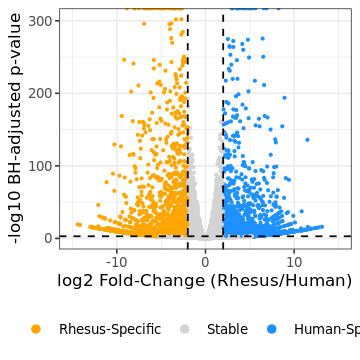

In [89]:
options(repr.plot.width = 3, repr.plot.height = 3)
p

In [90]:
ggsave(filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/RNA-expression_GM12878-vs-LCL8664_volcano.pdf", 
      plot = p, device = cairo_pdf, height = 3, width = 3)

Warning message:
“Removed 2876 rows containing missing values (geom_point).”


In [120]:
# how many differentially expressed genes?
dplyr::count(res_volcano, Classification)

Classification,n
<fct>,<int>
Rhesus-Specific,1470
Stable,16127
Human-Specific,1505


### QC plots

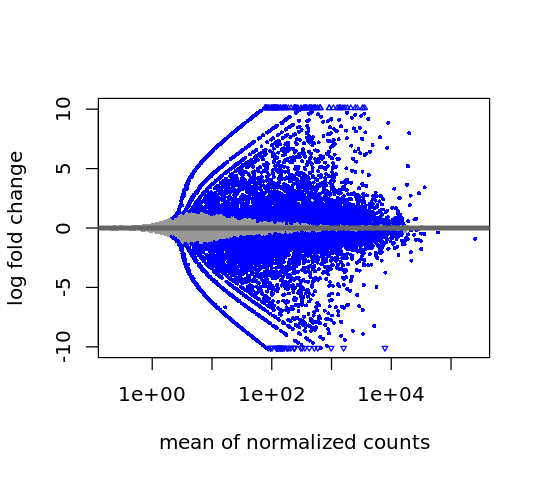

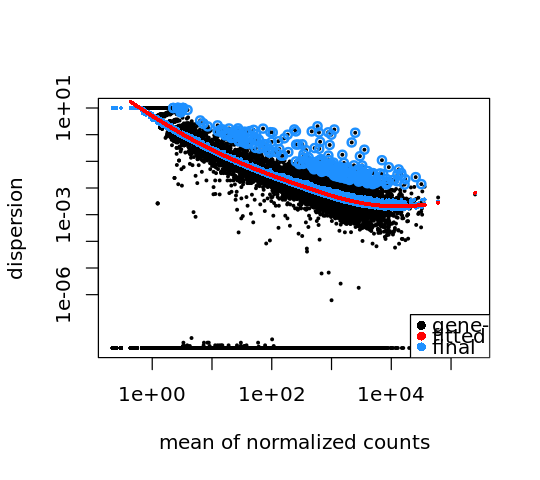

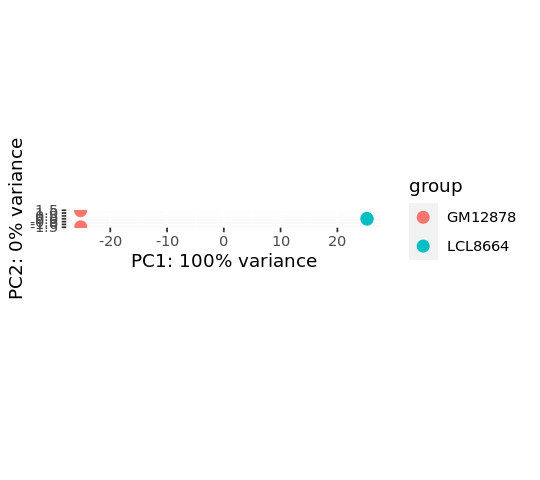

In [206]:
#MA plot (log ratio vs average counts). This shows shrinkage applied by apeglm. 
plotMA(res)
#Dispersion estimates plot shows how DESeq transformed values by dispersion estimation. 
p <- plotDispEsts(dds)
#PCA plot to see how samples group to see batch effects. To do this, first VST transform the values and plot. Do this not blind because we want the estimated dispersion applied to the differential analysis. 
vsd <- vst(dds, blind=FALSE, fitType = "local")
plotPCA(vsd, intgroup=c("condition"))

In [210]:
ggsave(plotPCA(vsd, intgroup=c("condition")), filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/QC_pca-plot.pdf", 
       device = cairo_pdf, width = 6, height = 6)

### Write out differential expression values for each gene

In [65]:
#convert ENS ID to symbol for sorting
library(org.Hs.eg.db)
gene_ids <- clusterProfiler::bitr(res_df$gene_id, fromType = "ENSEMBL", toType = "SYMBOL", OrgDb = org.Hs.eg.db, drop = TRUE)

head(gene_ids)

res_df_symbol <- left_join(gene_ids, res_df, by = c("ENSEMBL" = "gene_id"))

head(res_df_symbol)

'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(res_df$gene_id, fromType = "ENSEMBL", toType = "SYMBOL", :
“25.84% of input gene IDs are fail to map...”


,ENSEMBL,SYMBOL
,<chr>,<chr>
1,ENSG00000101557,USP14
2,ENSG00000079134,THOC1
3,ENSG00000158270,COLEC12
4,ENSG00000079101,CLUL1
5,ENSG00000176912,TYMSOS
6,ENSG00000176890,TYMS


,ENSEMBL,SYMBOL,baseMean,log2FoldChange,lfcSE,pvalue,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000101557,USP14,2058.430757,0.04475628,0.08388771,5.934085e-01,6.604463e-01
2,ENSG00000079134,THOC1,3652.802897,0.35321298,0.07468688,2.127846e-06,6.275251e-06
3,ENSG00000158270,COLEC12,1.192315,-0.03458565,0.96496285,9.119873e-01,9.326215e-01
4,ENSG00000079101,CLUL1,1.642457,-0.34805452,1.02984559,3.429982e-01,4.229737e-01
5,ENSG00000176912,TYMSOS,32.727864,-1.03588403,0.47657816,1.438164e-02,2.538968e-02
6,ENSG00000176890,TYMS,6184.079554,0.23224723,0.08213821,4.547235e-03,8.730735e-03


In [66]:
write_tsv(res_df_symbol, file = paste0(dir, 'diff_expression_res_gene-symbols.tsv'), col_names = TRUE)

### Focus on TFs only

In [67]:
#join to tsv that has symbols for TFs only. 
tfs <- read_tsv("~/TF_names_v_1.01.txt", col_names = c("gene_symbol"))

Rows: 1639 Columns: 1

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): gene_symbol


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [68]:
TFs_res <- inner_join(tfs, res_df_symbol, by = c("gene_symbol" = "SYMBOL"))

head(TFs_res)
nrow(TFs_res)

gene_symbol,ENSEMBL,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ADNP,ENSG00000101126,5629.855710,-0.5146161,0.06835355,4.448834e-14,2.417508e-13
ADNP2,ENSG00000101544,123.899723,0.4675264,0.24434095,4.879199e-02,7.731433e-02
AEBP1,ENSG00000106624,2.892439,-0.1077634,0.87439984,8.120623e-01,8.510866e-01
AEBP2,ENSG00000139154,1900.262281,-0.1088252,0.09286712,2.383493e-01,3.122945e-01
AHCTF1,ENSG00000153207,15.625232,-0.7606129,0.61321783,1.293900e-01,1.843327e-01
AHDC1,ENSG00000126705,462.715633,1.2231739,0.15039911,1.913067e-16,1.189783e-15


[1] 1347

In [69]:
write_tsv(TFs_res, file = paste0(dir, 'TFs-only_diff_expression_res_gene-symbols.tsv'), col_names = TRUE)

#### Volcano Text TF Differential Expression

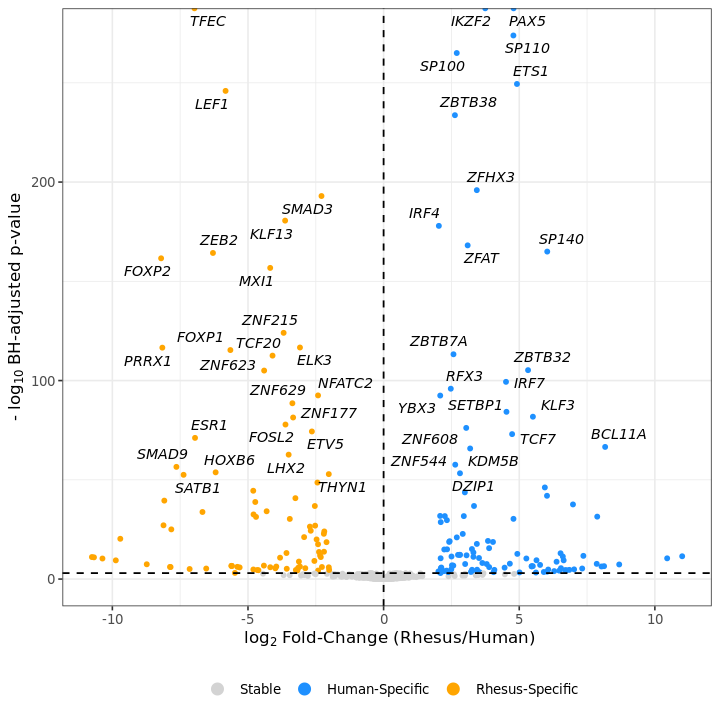

In [91]:
#Plot Volcano plot. First make a new column that classifies each region based on the cutoffs and then order the factored values. 
res_volcano_TF <- mutate(TFs_res, 
                      Classification = case_when(padj < 0.001 & log2FoldChange > 2 ~ "Rhesus-Specific", 
                                                             padj < 0.001 & log2FoldChange < -2 ~ "Human-Specific", 
                                                             padj >= 0.001 | (log2FoldChange == 0) ~ "Stable")) %>% filter(Classification != "NA")

res_volcano_TF$Classification <- factor(res_volcano_TF$Classification, levels = c("Stable","Human-Specific","Rhesus-Specific"))

res_volcano_text <- filter(res_volcano_TF, padj < 10^-50 & abs(log2FoldChange) > 2)

#Plot L2fc and -log10(padj) against each other and color by classificaiton above. 
p <- ggplot(res_volcano_TF, aes(x=-log2FoldChange, y=-log10(padj), colour=Classification)) +
  geom_point(size=1) +
  ggrepel::geom_text_repel(data = res_volcano_text, aes(x=-log2FoldChange, y=-log10(padj), label=gene_symbol), fontface = "italic", colour = "black", size = 3) +
  geom_hline(yintercept = c(-log10(0.001)), linetype = "dashed") +
  geom_vline(xintercept = c(0), linetype = "dashed") +
  xlab(bquote(~log[2]~"Fold-Change (Rhesus/Human)")) +
  ylab(bquote("-"~log[10]~"BH-adjusted p-value")) +
  theme_bw(base_size = 10, base_family = "Arial") +
  theme(legend.position="bottom", legend.title = element_blank()) +
  scale_colour_manual(values=c("lightgrey", "dodgerblue", "orange")) + 
  guides(colour = guide_legend(override.aes = list(size = 3)))

options(repr.plot.width = 6, repr.plot.height = 6)
p

In [92]:
ggsave(p, filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/gene_expression_evolution.pdf", 
       device = cairo_pdf, width = 6, height = 6)

### Correlation plot

In [93]:
#log normalize
joined_cts_tpm %<>% mutate(log_G1 = log10(1+TPM_G1)) %>%
    mutate(log_G2 = log10(1+TPM_G2)) %>%
    mutate(log_L1 = log10(1+TPM_L1)) %>%
    mutate(log_L2 = log10(1+TPM_L2)) %>%
    mutate(mean_log_G = (log_G1+log_G2)/2) %>%
    mutate(mean_log_L = (log_L1+log_L2)/2)

In [99]:
cor.test(joined_cts_tpm$mean_log_G, joined_cts_tpm$mean_log_L, method = "spearman")
cor.test(joined_cts_tpm$mean_log_G, joined_cts_tpm$mean_log_L, method = "pearson")

Warning message in cor.test.default(joined_cts_tpm$mean_log_G, joined_cts_tpm$mean_log_L, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  joined_cts_tpm$mean_log_G and joined_cts_tpm$mean_log_L
S = 4.8357e+11, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8489469 



	Pearson's product-moment correlation

data:  joined_cts_tpm$mean_log_G and joined_cts_tpm$mean_log_L
t = 315.93, df = 26779, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8853919 0.8904596
sample estimates:
      cor 
0.8879527 


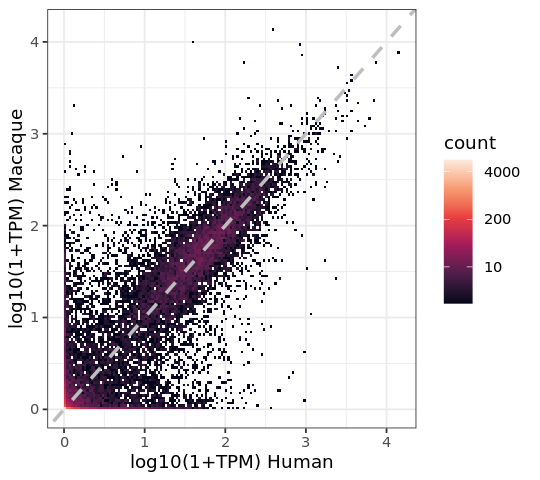

In [196]:
p <- ggplot(joined_cts_tpm, aes(x = mean_log_G, y = mean_log_L)) +
    geom_bin_2d(bins = 150) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", lwd = 1, color = "grey") +
    scale_fill_viridis_c(trans = "log", breaks = c(0, 10, 200, 4000), option = "rocket") +
    labs(x = "log10(1+TPM) Human", y = "log10(1+TPM) Macaque") +
    theme_bw()

options(repr.plot.width = 4.5, repr.plot.height = 4)
p

In [197]:
ggsave(p, filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/expression_correlation.pdf", 
       device = cairo_pdf, width = 4.5, height = 4)

### Pathway enrichment of the differentially expressed genes

In [103]:
library(ReactomePA)

ReactomePA v1.38.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pathway analysis and visualization. Molecular BioSystems 2016, 12(2):477-479



In [141]:
#split results
res_volcano$Classification %<>% as.character()
human <- dplyr::filter(res_volcano, Classification == "Human-Specific")
macaque <- dplyr::filter(res_volcano, Classification == "Rhesus-Specific")

In [142]:
# get entrez
human_gene <- clusterProfiler::bitr(geneID = human$gene_id, OrgDb = org.Hs.eg.db, fromType = "ENSEMBL", toType = "ENTREZID")
macaque_gene <- clusterProfiler::bitr(geneID = macaque$gene_id, OrgDb = org.Hs.eg.db, fromType = "ENSEMBL", toType = "ENTREZID")

'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(geneID = human$gene_id, OrgDb = org.Hs.eg.db, :
“14.35% of input gene IDs are fail to map...”
'select()' returned 1:many mapping between keys and columns

Warning message in clusterProfiler::bitr(geneID = macaque$gene_id, OrgDb = org.Hs.eg.db, :
“8.98% of input gene IDs are fail to map...”


In [143]:
#pathway enrichment
res_hu <- enrichPathway(gene = human_gene$ENTREZID, pvalueCutoff = 0.2, pAdjustMethod = "none")
res_ma <- enrichPathway(gene = macaque_gene$ENTREZID, pvalueCutoff = 0.2, pAdjustMethod = "none")

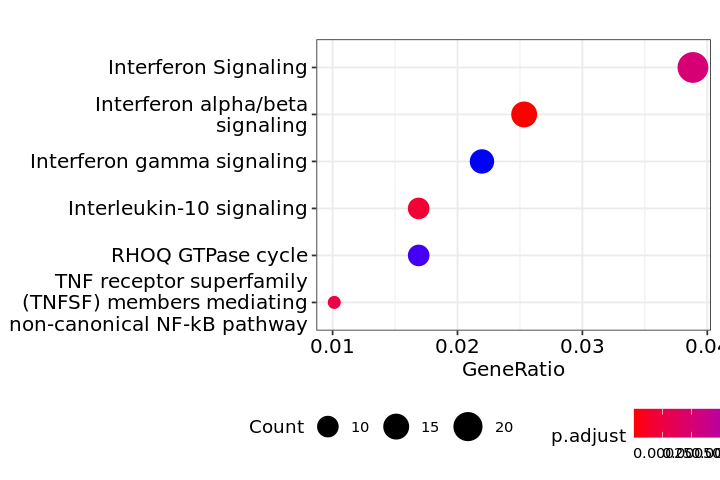

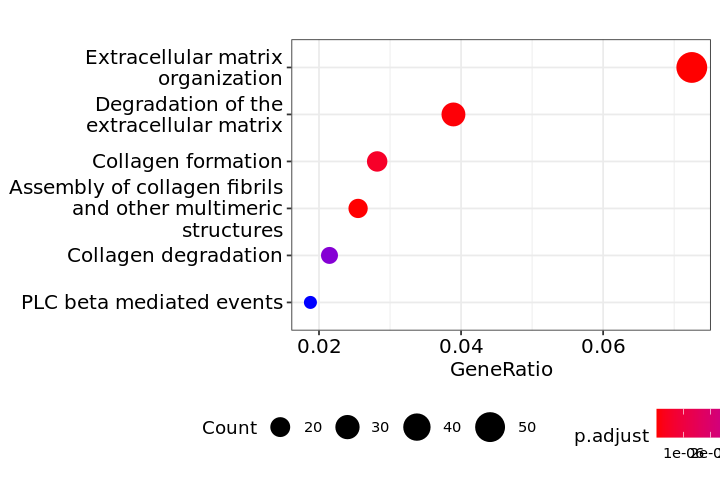

In [169]:
options(repr.plot.width = 6, repr.plot.height = 4)
dotplot(res_hu, showCategory = 6) + theme(legend.position = "bottom") 
dotplot(res_ma, showCategory = 6) + theme(legend.position = "bottom")

In [170]:
ggsave(dotplot(res_hu, showCategory = 6) + theme(legend.position = "bottom"), filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/reactome_human.pdf", 
       device = cairo_pdf, width = 6, height = 4)

In [171]:
ggsave(dotplot(res_ma, showCategory = 6) + theme(legend.position = "bottom"), filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/reactome_mac.pdf", 
       device = cairo_pdf, width = 6, height = 4)

In [172]:
library(clusterProfiler)

clusterProfiler v4.2.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter




In [173]:
gene_list <- list(human = human_gene$ENTREZID, macaque = macaque_gene$ENTREZID)
result <- compareCluster(gene_list, fun = "enrichPathway", pvalueCutoff = 0.2, pAdjustMethod = "none")

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



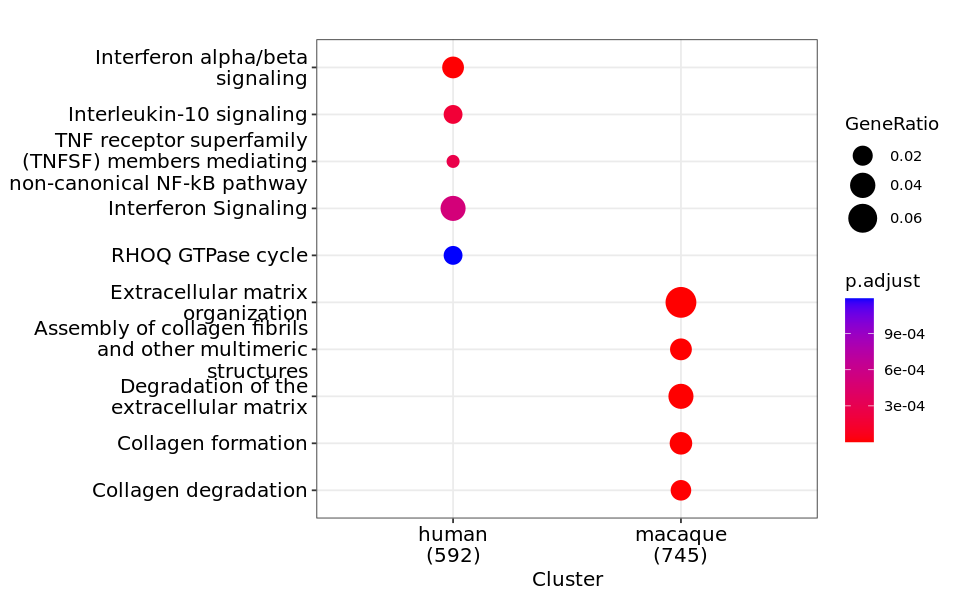

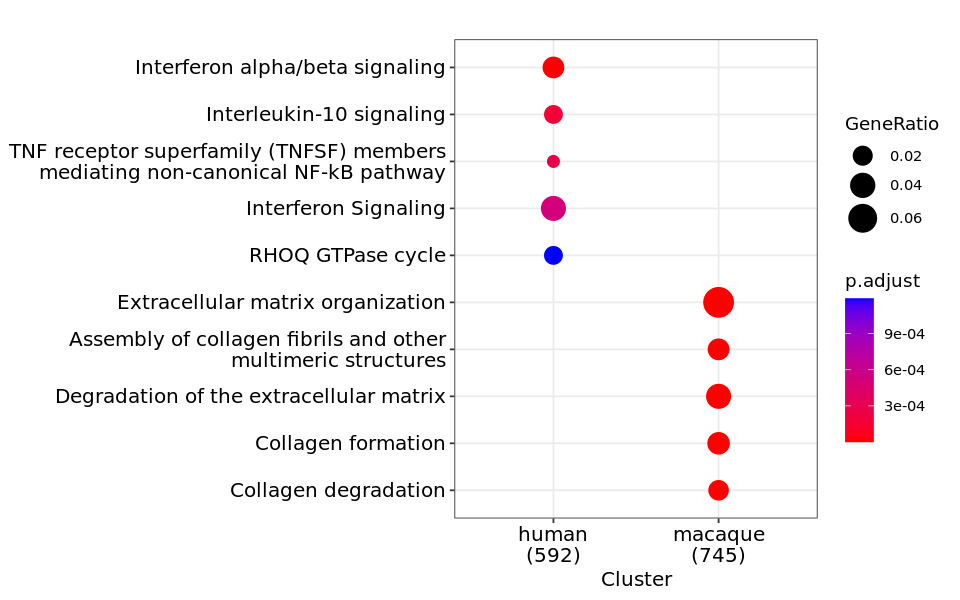

In [186]:
options(repr.plot.width = 8, repr.plot.height = 5)
dotplot(result, showCategory = 5) + scale_y_discrete(labels = function(x) str_wrap(x, width = 40))

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



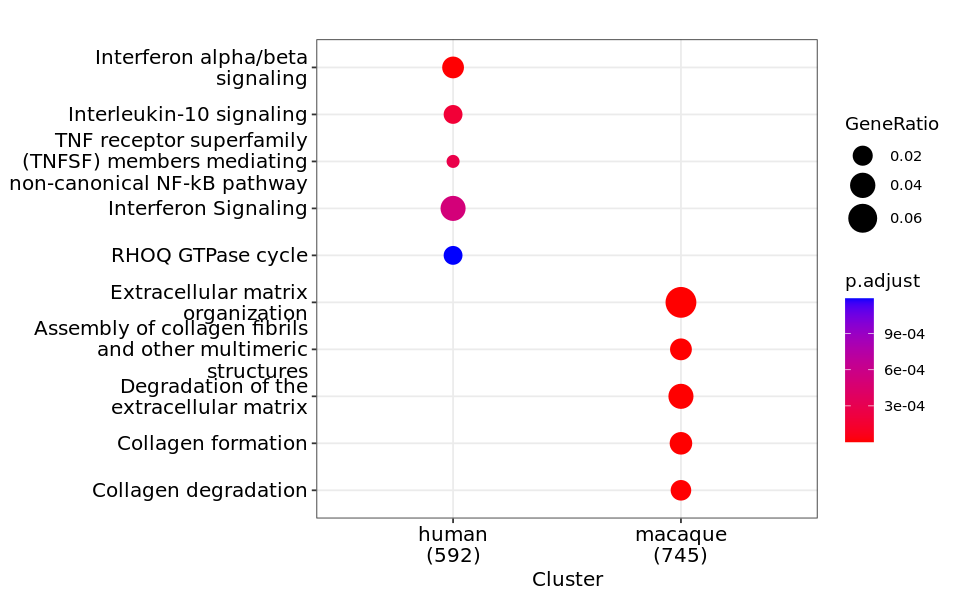

In [188]:
p <- dotplot(result, showCategory = 5) + scale_y_discrete(labels = function(x) str_wrap(x, width = 40))

In [189]:
ggsave(p, filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/reactome_all.pdf", 
       device = cairo_pdf, width = 8, height = 5)

## Plot ETS1 and RUNX3 TPM values

In [3]:
library(tidyverse)

tpm <- read_tsv("/data/hodges_lab/ATAC-STARR_B-cells/data/RNA-seq/GM12878+LCL8664_TPM-normalized_counts.tsv") %>%
    filter(SYMBOL %in% c("ETS1", "RUNX3")) %>% select(-gene_id)

Rows: 26781 Columns: 6

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): gene_id, SYMBOL
dbl (4): TPM_G1, TPM_G2, TPM_L1, TPM_L2


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [4]:
tpm_long <- pivot_longer(tpm, !SYMBOL, names_to = "sample", values_to = "TPM") %>% 
    mutate(species = case_when(sample %in% c("TPM_G1", "TPM_G2") ~ "human",
                               sample %in% c("TPM_L1", "TPM_L2") ~ "macaque")) %>%
    mutate(rep = case_when(sample %in% c("TPM_G1", "TPM_L1") ~ "rep1",
                               sample %in% c("TPM_G2", "TPM_L2") ~ "rep2"))

tpm_long

SYMBOL,sample,TPM,species,rep
<chr>,<chr>,<dbl>,<chr>,<chr>
RUNX3,TPM_G1,108.206800,human,rep1
RUNX3,TPM_G2,123.797857,human,rep2
RUNX3,TPM_L1,88.424290,macaque,rep1
RUNX3,TPM_L2,83.501038,macaque,rep2
ETS1,TPM_G1,179.424393,human,rep1
ETS1,TPM_G2,184.254039,human,rep2
ETS1,TPM_L1,6.192766,macaque,rep1
ETS1,TPM_L2,5.845492,macaque,rep2


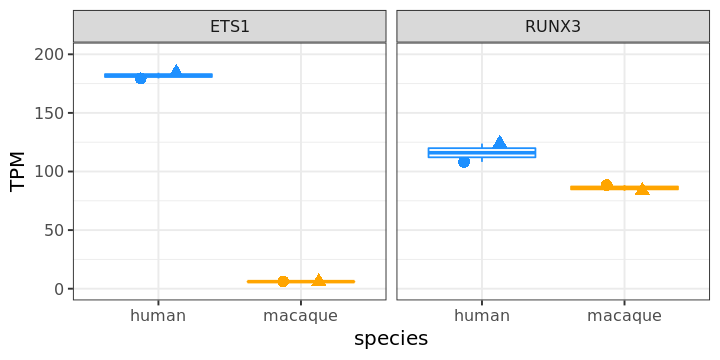

In [12]:
options(repr.plot.width = 6, repr.plot.height = 3)

p <- ggplot(tpm_long, aes(x = species, y = TPM, color = species)) +
    geom_point(aes(shape=rep),size = 3, position = position_dodge2(width = 0.5)) +
    geom_boxplot() +
    facet_wrap(~SYMBOL) +
    theme_bw(base_size = 12) +
    theme(legend.position = "none") +
    scale_color_manual(values = c("dodgerblue", "orange")) +
    coord_cartesian(ylim = c(0,200))

p

In [13]:
ggsave(p, filename = "/data/hodges_lab/ATAC-STARR_B-cells/results/results_human-evolution/ets1+runx3_tpm.pdf", 
       device = cairo_pdf, width = 6, height = 3)